In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import scipy.ndimage as ndi 
import os
import numpy as np
from nilearn import plotting
from nilearn import datasets
import cv2
from PIL import Image
import pandas as pd

In [5]:


example_filename = r"/Users/mihnea/_workspace_/_uni/workshop/fmri_data/input_images/sub-CSI1/ses-1/sub-CSI1_ses-1_task-5000scenes_run-1_bold.nii.gz"

img = nib.load(example_filename)
print(img.shape)  # Print the dimensions of the image
#print(img.get_fdata())

(106, 106, 69, 194)


/Users/mihnea/_workspace_/_uni/workshop/fmri_data/venv/lib/python3.11/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


[255 255 255 ... 255 255 255]


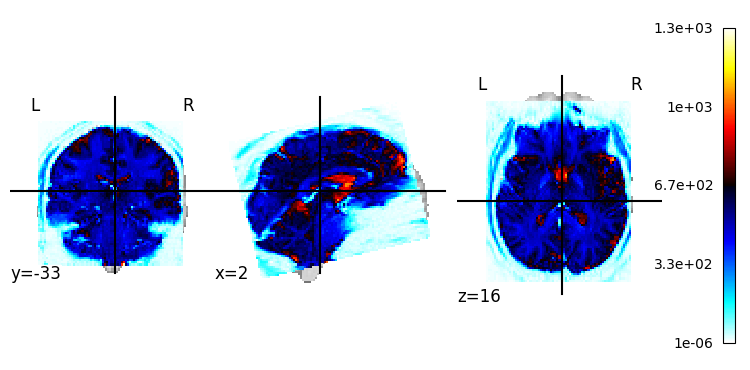

In [6]:
# Creates the plot, saves it and then loads it up again to get the vector of the image. The vector isn't coming out right and is just [255, 255, 255, ... , 255, 255]
img = plotting.plot_stat_map(img.slicer[20:90, 10:95, :, 0])

plt.savefig(r"/Users/mihnea/_workspace_/_uni/workshop/fmri_data/output_images/temp_plot_2.png") #change the directory to where you want to save the file

img_pil = Image.open(r"/Users/mihnea/_workspace_/_uni/workshop/fmri_data/output_images/temp_plot_2.png") #change the directory to where the file is saved, should be the directory you're in

img_array = np.array(img_pil)

print(img_array.ravel())

In [ ]:
# Define a function to read your TSV data into a DataFrame
def read_tsv_file(file_path):
    return pd.read_csv(file_path, sep='\t')

# Assuming you have multiple subject folders containing both fMRI data and TSV files
subject_folder = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/images/subject_1"

# Loop over subjects (assuming each subject has a specific folder)
for subject_file in os.listdir(subject_folder):
    if subject_file.endswith(".tsv"):
        tsv_data = read_tsv_file(os.path.join(subject_folder, subject_file))
        
        # Extract relevant columns from the TSV data
        onset_times = tsv_data['onset']
        image_names = tsv_data['ImgName']

        # Load corresponding fMRI data for this subject
        fMRI_file = os.path.join(subject_folder, "fmri_data", "images", f"sub-{subject_file}_task-5000scenes_run-02_events.nii.gz")
        img = nib.load(fMRI_file)

        # Loop over each event and save the corresponding brain activation image
        for i in range(len(onset_times)):
            onset = onset_times[i]
            image_name = image_names[i]

            # Determine the corresponding timepoint in the fMRI data (convert onset time to index)
            time_index = int(onset / img.header['pixdim'][4])  # Assuming TR (Repetition Time) is in pixdim[4]

            # Extract the activation image at this time index
            activation_img = img.slicer[..., time_index]

            # Save the activation image with the associated image name
            output_path = os.path.join(subject_folder, "output_images", f"{image_name}.png")
            plotting.plot_stat_map(activation_img).savefig(output_path)

            print(f"Saved image for event '{image_name}' at time {onset} seconds.")


In [ ]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import plotting

# Function to read TSV data into a DataFrame
def read_tsv_file(file_path):
    return pd.read_csv(file_path, sep='\t')

# Specify the main directory containing subject data
data_dir = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/images"

# Iterate over each subject folder
for subject_folder in os.listdir(data_dir):
    subject_path = os.path.join(data_dir, subject_folder)
    
    if os.path.isdir(subject_path):
        print(f"Processing subject: {subject_folder}")
        
        # Iterate over each run for the subject
        for file in os.listdir(subject_path):
            if file.endswith(".nii.gz"):
                nii_file_path = os.path.join(subject_path, file)
                run_name = file.split("_")[4]  # Extract run number from filename
                tsv_file_path = os.path.join(subject_path, f"sub-{subject_folder}_task-5000scenes_{run_name}_events.tsv")

                if os.path.exists(tsv_file_path):
                    # Load the NIfTI fMRI data
                    img = nib.load(nii_file_path)

                    # Read the TSV file to extract event information
                    tsv_data = read_tsv_file(tsv_file_path)
                    onset_times = tsv_data['StimOn(s)']
                    stim_off_times = tsv_data['StimOff(s)']
                    image_names = tsv_data['ImgName']
                    trial_numbers = tsv_data['Trial']
                    run_numbers = tsv_data['Run']

                    # Get the run number
                    run_number = int(run_name.split("-")[1])  # Extract numeric run number

                    # Construct the output folder path based on subject and run
                    output_folder = f"./output_images/{subject_folder}/run_{run_number}"
                    os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

                    # Loop over each event and save corresponding activation image
                    for i in range(len(onset_times)):
                        onset = onset_times[i]
                        stim_off = stim_off_times[i]
                        image_name = image_names[i]
                        trial_number = trial_numbers[i]

                        # Calculate time index based on stim_off time and TR
                        time_index = int(stim_off / img.header['pixdim'][4])  # Assuming TR is in pixdim[4]

                        # Extract the activation image at the specified time index
                        activation_img = img.slicer[..., time_index]

                        # Convert activation image data to float32
                        activation_img_data = activation_img.get_fdata().astype(np.float32)
                        activation_img = nib.Nifti1Image(activation_img_data, img.affine)

                        # Construct the output filename with subject info, run, trial, and image name
                        output_filename = f"fMRI_{subject_folder}_run_{run_number}_trial_{trial_number}_{image_name.split('.')[0]}.png"
                        output_path = os.path.join(output_folder, output_filename)

                        # Plot and save the activation image
                        plotting.plot_stat_map(activation_img).savefig(output_path)

                        # Close the current figure to avoid memory issues
                        plt.close()

                        print(f"Saved image for event '{image_name}' at StimOff time {stim_off} seconds as {output_filename} in {output_folder}.")
                else:
                    print(f"TSV file not found for run: {run_name}")
    else:
        print(f"Skipping non-directory: {subject_folder}")


In [20]:
# Function to read TSV data into a DataFrame
def read_tsv_file(file_path):
    return pd.read_csv(file_path, sep='\t')

# Define paths to the NIfTI and TSV files for one specific run
nii_file_path = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/images/subject_1/input_images/sub-CSI1_ses-01_task-5000scenes_run-10_events.nii.gz"
tsv_file_path = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/images/subject_1/input_images/sub-CSI1_ses-01_task-5000scenes_run-10_events.tsv"

# Load the NIfTI fMRI data
img = nib.load(nii_file_path)

# Read the TSV file to extract event information
tsv_data = read_tsv_file(tsv_file_path)
onset_times = tsv_data['StimOn(s)']
stim_off_times = tsv_data['StimOff(s)']
image_names = tsv_data['ImgName']
trial_numbers = tsv_data['Trial']
run_numbers = tsv_data['Run']

# Loop over each event and save corresponding activation image
for i in range(len(onset_times)):
    onset = onset_times[i]
    stim_off = stim_off_times[i]
    image_name = image_names[i]
    trial_number = trial_numbers[i]
    run_number = run_numbers[i]

    # Calculate time index based on stim_off time and TR
    time_index = int(stim_off / img.header['pixdim'][4])  # Assuming TR is in pixdim[4]

    # Extract the activation image at the specified time index
    activation_img = img.slicer[..., time_index]

    # Convert activation image data to float32
    activation_img_data = activation_img.get_fdata().astype(np.float32)
    activation_img = nib.Nifti1Image(activation_img_data, img.affine)

    # Construct the output filename with subject info, run, trial, and image name
    output_filename = f"fMRI_subject_1_run_{run_number}_trial_{trial_number}_{image_name.split('.')[0]}.png"
    output_folder = f"./output_images/run_{run_number}"  # Output folder in current directory
    os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist
    output_path = os.path.join(output_folder, output_filename)

    # Save the activation image with the constructed filename
    plotting.plot_stat_map(activation_img).savefig(output_path)
    
    plt.close()

    print(f"Saved image for event '{image_name}' at StimOff time {stim_off} seconds as {output_filename}.")


Saved image for event 'n07734744_18382.JPEG' at StimOff time 7.0074 seconds as fMRI_subject_1_run_10_trial_1_n07734744_18382.png.
Saved image for event 'COCO_train2014_000000073172.jpg' at StimOff time 16.9991 seconds as fMRI_subject_1_run_10_trial_2_COCO_train2014_000000073172.png.
Saved image for event 'pharmacy4.jpg' at StimOff time 27.0074 seconds as fMRI_subject_1_run_10_trial_3_pharmacy4.png.
Saved image for event 'bakerykitchen.jpg' at StimOff time 36.9992 seconds as fMRI_subject_1_run_10_trial_4_bakerykitchen.png.
Saved image for event 'n07711569_4744.JPEG' at StimOff time 47.0076 seconds as fMRI_subject_1_run_10_trial_5_n07711569_4744.png.
Saved image for event 'wrestlingring6.jpg' at StimOff time 56.9993 seconds as fMRI_subject_1_run_10_trial_6_wrestlingring6.png.
Saved image for event 'COCO_train2014_000000142958.jpg' at StimOff time 67.0076 seconds as fMRI_subject_1_run_10_trial_7_COCO_train2014_000000142958.png.
Saved image for event 'n03709823_25687.JPEG' at StimOff time 

In [1]:
# function to make images from all subjects at once

import os
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt


# Function to read TSV data into a DataFrame
def read_tsv_file(file_path):
    return pd.read_csv(file_path, sep='\t')


# Main function to process fMRI data
def process_fmri_data(data_dir, output_dir):
    # Iterate over each subject folder
    for subject_folder in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_folder)

        if os.path.isdir(subject_path):
            print(f"Processing subject: {subject_folder}")

            # Iterate over each session folder for the subject
            for session_folder in os.listdir(subject_path):
                session_path = os.path.join(subject_path, session_folder)

                if os.path.isdir(session_path):
                    print(f"Processing session: {session_folder}")

                    # Iterate over each file in the session folder
                    for file in os.listdir(session_path):
                        # Check if the file is a NIfTI file
                        if file.endswith(".nii.gz"):
                            # Extract run name from bold filename
                            run_name = file.split("_")[3]
                            tsv_file_name = f"{subject_folder}_{session_folder}_task-5000scenes_{run_name}_events.tsv"
                            tsv_file_path = os.path.join(session_path, tsv_file_name)

                            if os.path.exists(tsv_file_path):
                                # Load the NIfTI fMRI data
                                img = nib.load(os.path.join(session_path, file))

                                # Read the TSV file to extract event information
                                tsv_data = read_tsv_file(tsv_file_path)
                                onset_times = tsv_data['StimOn(s)']
                                stim_off_times = tsv_data['StimOff(s)']
                                image_names = tsv_data['ImgName']
                                trial_numbers = tsv_data['Trial']

                                # Create output folder for this subject and session
                                output_folder = os.path.join(output_dir, f"subject_{subject_folder}",
                                                             f"ses-{session_folder}", f"run_{run_name}")
                                os.makedirs(output_folder, exist_ok=True)

                                # Loop over each event and save corresponding activation image
                                for i in range(len(onset_times)):
                                    onset = onset_times[i]
                                    stim_off = stim_off_times[i]
                                    image_name = image_names[i]
                                    trial_number = trial_numbers[i]

                                    # Calculate time index based on stim_off time and TR
                                    time_index = int(stim_off / img.header['pixdim'][4])

                                    # Extract the activation image at the specified time index
                                    activation_img = img.slicer[..., time_index]

                                    # Convert activation image data to float32
                                    activation_img_data = activation_img.get_fdata().astype(np.float32)
                                    activation_img = nib.Nifti1Image(activation_img_data, img.affine)

                                    # Construct the output filename for the activation image
                                    output_filename = f"fMRI_subject_{subject_folder}_ses-{session_folder}_run_{run_name}_trial_{trial_number}_{image_name.split('.')[0]}.png"
                                    output_path = os.path.join(output_folder, output_filename)

                                    # Plot and save the activation image
                                    plotting.plot_stat_map(activation_img).savefig(output_path)

                                    # Close the current figure to avoid memory issues
                                    plt.close()

                                    print(
                                        f"Saved image for event '{image_name}' at StimOff time {stim_off} seconds as {output_filename} in {output_folder}.")
                            else:
                                print(f"TSV file not found for run: {run_name}")


if __name__ == "__main__":
    # Specify the main directory containing subject data and the output directory
    data_directory = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/images"
    output_directory = "/Users/mihnea/_workspace_/_uni/workshop/fmri_data/output_images"

    # Call the main processing function
    process_fmri_data(data_directory, output_directory)


Processing subject: sub_CSI1
Processing session: ses-10
TSV file not found for run: run-09
TSV file not found for run: run-05
TSV file not found for run: run-10
TSV file not found for run: run-06
TSV file not found for run: run-03
TSV file not found for run: run-04
TSV file not found for run: run-01
TSV file not found for run: run-08
TSV file not found for run: run-02
TSV file not found for run: run-07
Processing session: ses-11
TSV file not found for run: bold.nii.gz
TSV file not found for run: run-06
TSV file not found for run: run-03
TSV file not found for run: run-09
TSV file not found for run: run-05
TSV file not found for run: run-02
TSV file not found for run: run-07
TSV file not found for run: run-04
TSV file not found for run: run-01
TSV file not found for run: run-08
Processing session: ses-02
TSV file not found for run: run-09
TSV file not found for run: run-05
TSV file not found for run: run-10
TSV file not found for run: run-06
TSV file not found for run: run-03
TSV file n